###DATA PROCESSING & 5 QUESTIONS

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import plotly.express as px

import kagglehub


/Users/lacmichael/Documents/School/CS/cs133/cs133-proj/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download(
    "artyomkruglov/gaming-profiles-2025-steam-playstation-xbox"
)
print("Base path:", path)

csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
csv_files

Base path: /Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1


['/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/purchased_games.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/reviews.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/history.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/friends.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/prices.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/players.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/versions/1/steam/games.csv',
 '/Users/lacmichael/.cache/kagglehub/datasets/arty

In [3]:
# Construct the path to the playstation prices.csv
playstation_prices_path = os.path.join(path, "playstation", "prices.csv")

if os.path.exists(playstation_prices_path):
    playstation_prices_df = pd.read_csv(playstation_prices_path)
    print("\nPlayStation prices.csv - Head:")
    display(playstation_prices_df.head())
    print("\nPlayStation prices.csv - Columns:")
    print(playstation_prices_df.columns.tolist())
else:
    print(f"File not found: {playstation_prices_path}")

# Repeat for xbox prices.csv
xbox_prices_path = os.path.join(path, "xbox", "prices.csv")
if os.path.exists(xbox_prices_path):
    xbox_prices_df = pd.read_csv(xbox_prices_path)
    print("\nXbox prices.csv - Head:")
    display(xbox_prices_df.head())
    print("\nXbox prices.csv - Columns:")
    print(xbox_prices_df.columns.tolist())
else:
    print(f"File not found: {xbox_prices_path}")

# Repeat for steam prices.csv
steam_prices_path = os.path.join(path, "steam", "prices.csv")
if os.path.exists(steam_prices_path):
    steam_prices_df = pd.read_csv(steam_prices_path)
    print("\nSteam prices.csv - Head:")
    display(steam_prices_df.head())
    print("\nSteam prices.csv - Columns:")
    print(steam_prices_df.columns.tolist())
else:
    print(f"File not found: {steam_prices_path}")



PlayStation prices.csv - Head:


,gameid,usd,eur,gbp,jpy,rub,date_acquired
0,749347,10.39,10.39,7.99,1408.0,929.0,2025-02-22
1,749281,1.49,1.49,1.19,220.0,NaN,2025-02-22
2,749839,14.99,14.99,11.99,2310.0,1069.0,2025-02-22
3,749280,1.49,1.49,1.19,220.0,NaN,2025-02-22
4,749375,0.99,0.49,0.39,165.0,71.0,2025-02-22



PlayStation prices.csv - Columns:
['gameid', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'date_acquired']

Xbox prices.csv - Head:


,gameid,usd,eur,gbp,jpy,rub,date_acquired
0,1253,19.99,19.99,15.99,NaN,1772.0,2025-02-22
1,727440,17.99,17.99,14.99,NaN,1595.0,2025-02-22
2,747995,4.79,4.79,3.99,NaN,425.0,2025-02-22
3,727135,17.99,17.99,14.99,NaN,1595.0,2025-02-22
4,748541,19.99,19.99,16.74,NaN,1772.0,2025-02-22



Xbox prices.csv - Columns:
['gameid', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'date_acquired']

Steam prices.csv - Head:


,gameid,usd,eur,gbp,jpy,rub,date_acquired
0,3281560,NaN,NaN,NaN,NaN,NaN,2024-11-28
1,3280930,NaN,NaN,NaN,NaN,NaN,2024-11-28
2,3280770,NaN,NaN,NaN,NaN,NaN,2024-11-28
3,3279790,NaN,NaN,NaN,NaN,NaN,2024-11-28
4,3278320,NaN,NaN,NaN,NaN,NaN,2024-11-28



Steam prices.csv - Columns:
['gameid', 'usd', 'eur', 'gbp', 'jpy', 'rub', 'date_acquired']


In [4]:
def load_platform_games(base_path, platform_name):
    """
    base_path: path returned by kagglehub
    platform_name: 'steam', 'playstation', or 'xbox'
    """
    platform_dir = os.path.join(base_path, platform_name)

    games_path = os.path.join(platform_dir, "games.csv")
    prices_path = os.path.join(platform_dir, "prices.csv")

    games = pd.read_csv(games_path)
    games["platform"] = platform_name

    # Normalize game ID column in 'games' DataFrame
    if "gameid" in games.columns:
        games = games.rename(columns={"gameid": "game_id"})
    elif "id" in games.columns:
        games = games.rename(columns={"id": "game_id"})
    # If 'game_id' is still not found, the merge will likely fail later, but we ensure 'prices' column exists.

    # Attempt to load and merge prices
    if os.path.exists(prices_path):
        prices_df = pd.read_csv(prices_path) # Renamed to prices_df to avoid conflict with final column name

        # Normalize game ID column in 'prices_df' DataFrame
        if "gameid" in prices_df.columns:
            prices_df = prices_df.rename(columns={"gameid": "game_id"})
        elif "id" in prices_df.columns:
            prices_df = prices_df.rename(columns={"id": "game_id"})

        latest_prices = prices_df
        if "date_acquired" in prices_df.columns: # Changed from 'date' to 'date_acquired' based on inspection
            prices_df["date_acquired"] = pd.to_datetime(prices_df["date_acquired"])
            latest_prices = (
                prices_df.sort_values("date_acquired")
                      .groupby("game_id")
                      .tail(1)
            )

        # Identify the actual price column name - prioritize 'usd'
        price_column_name = None
        if 'usd' in latest_prices.columns:
            price_column_name = 'usd'
        # Add other currency columns if 'usd' is not available or desired
        elif 'eur' in latest_prices.columns:
            price_column_name = 'eur'
        elif 'gbp' in latest_prices.columns:
            price_column_name = 'gbp'
        # Fallback to general price names if no currency found
        for col in ['price', 'current_price', 'retail_price', 'final_price']:
            if col in latest_prices.columns:
                price_column_name = col
                break

        if price_column_name is None:
            print(f"Warning: No identifiable price column (checked 'usd', 'eur', 'gbp', 'price', etc.) found in prices.csv for {platform_name}. Adding 'prices' column with NaNs.")
        else:
            # Merge the identified price column
            if "game_id" in games.columns and "game_id" in latest_prices.columns:
                games = games.merge(
                    latest_prices[["game_id", price_column_name]],
                    on="game_id",
                    how="left"
                )
                # Rename the identified price column to 'prices'
                games = games.rename(columns={price_column_name: "prices"})
            else:
                print(f"Warning: Could not merge price data for {platform_name}. 'game_id' column might be missing after normalization. Adding 'prices' column with NaNs.")

    # Ensure 'prices' column exists in the final DataFrame, even if no merge occurred or merge failed
    if "prices" not in games.columns:
        games["prices"] = np.nan

    return games

playstation_games = load_platform_games(path, "playstation")
xbox_games = load_platform_games(path, "xbox")
steam_games = load_platform_games(path, "steam")

games_all = pd.concat([playstation_games, xbox_games, steam_games], ignore_index=True)

games_all.head()

,game_id,title,platform,developers,publishers,genres,supported_languages,release_date,prices
0,749375,Medieval Match Master,playstation,['Erik Games'],['Erik Games'],['Puzzle'],NaN,2024-11-22,0.99
1,749839,Sunforge Solar Survival,playstation,['GrizzlyGames'],['GrizzlyGames'],NaN,NaN,2024-11-21,14.99
2,749347,Find Love Or Die Trying,playstation,['Sunseeker Games'],['Ratalaika Games'],['Visual Novel'],NaN,2024-11-22,10.39
3,749341,Medieval Match Master,playstation,['Erik Games'],['Erik Games'],['Puzzle'],NaN,2024-11-22,0.99
4,749097,Bust A Block 2,playstation,['ThiGames'],['ThiGames'],['Puzzle'],NaN,2024-11-21,1.49


In [5]:
df = games_all.copy()

df = df.dropna(subset=["prices"])

# Parse release date (adjust actual column name, e.g. 'release_date', 'released_at')
if "release_date" in df.columns:
    df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
    df["release_year"] = df["release_date"].dt.year
else:
    df["release_year"] = np.nan

# Simplify genres (first genre if multiple separated by ';' or ',')
genre_col = "genre" if "genre" in df.columns else "genres"
if genre_col in df.columns:
    df[genre_col] = df[genre_col].astype(str).str.split("[,;]").str[0].str.strip()
    # Additional cleaning: remove brackets and quotes
    df[genre_col] = df[genre_col].str.replace(r"[\['\\]]", "", regex=True).str.strip()

df["prices"] = df["prices"].astype(float)

def label_high_price(group):
    threshold = group["prices"].quantile(0.75)
    return (group["prices"] >= threshold).astype(int)

if not df.empty:
    df["is_high_price"] = df.groupby("platform")["prices"].transform(
        lambda x: (x >= x.quantile(0.75, interpolation='lower')).astype(int) if not x.empty else pd.Series(dtype=int)
    )
else:
    df["is_high_price"] = pd.Series(dtype=int)

df["is_high_price"].value_counts(normalize=True)


is_high_price
0    0.670963
1    0.329037
Name: proportion, dtype: float64

###Q1: How are prices distributed across platforms?

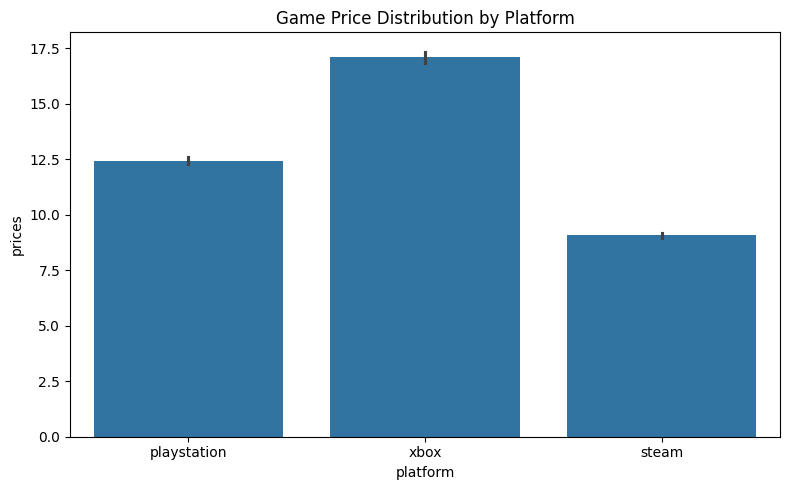

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="platform", y="prices")
plt.title("Game Price Distribution by Platform")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

###Q2: How did the number of releases evolve over time?

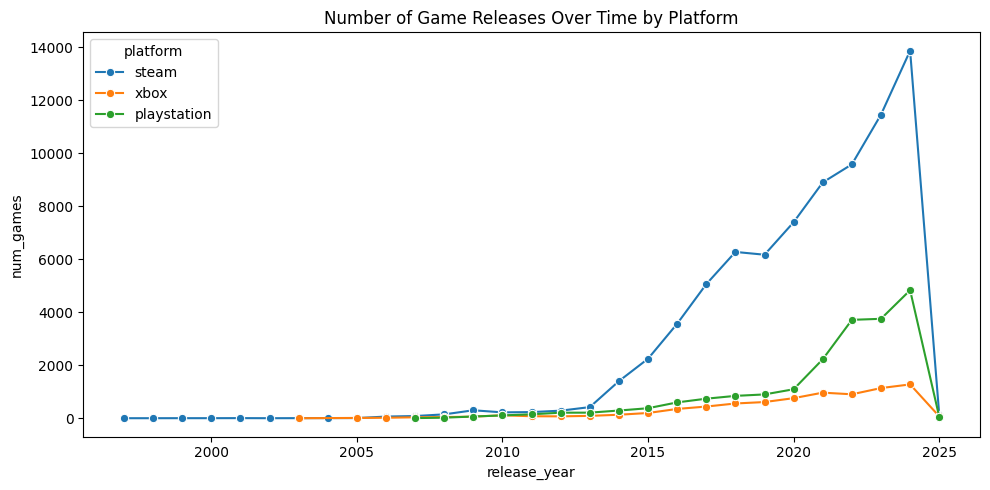

In [7]:
release_df = df.dropna(subset=["release_year"])
release_counts = (
    release_df.groupby(["release_year", "platform"])
              .size()
              .reset_index(name="num_games")
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=release_counts, x="release_year", y="num_games",
             hue="platform", marker="o")
plt.title("Number of Game Releases Over Time by Platform")
plt.tight_layout()
plt.show()

###Q3: What are the 10 most common genres on each platform and across all platforms?


####Normal Version

In [8]:
# Processing the genres to avoid any duplicates
import re

genre_col = "genre" if "genre" in df.columns else "genres"

def clean_genre(s):
    if pd.isna(s):
        return "unknown"
    s = str(s)

    # Keep only the first genre before separators
    s = re.split(r"[,;/\|]", s)[0]

    # Remove brackets, quotes, backslashes
    s = re.sub(r"[\"'\[\]\\]", "", s)

    # Normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    # Normalize case
    s = s.lower()

    return s if s != "" else "unknown"

if genre_col in df.columns:
    df[genre_col] = df[genre_col].apply(clean_genre)

df["genres"] = df[genre_col].str.title()
display_genre_col = "genres"


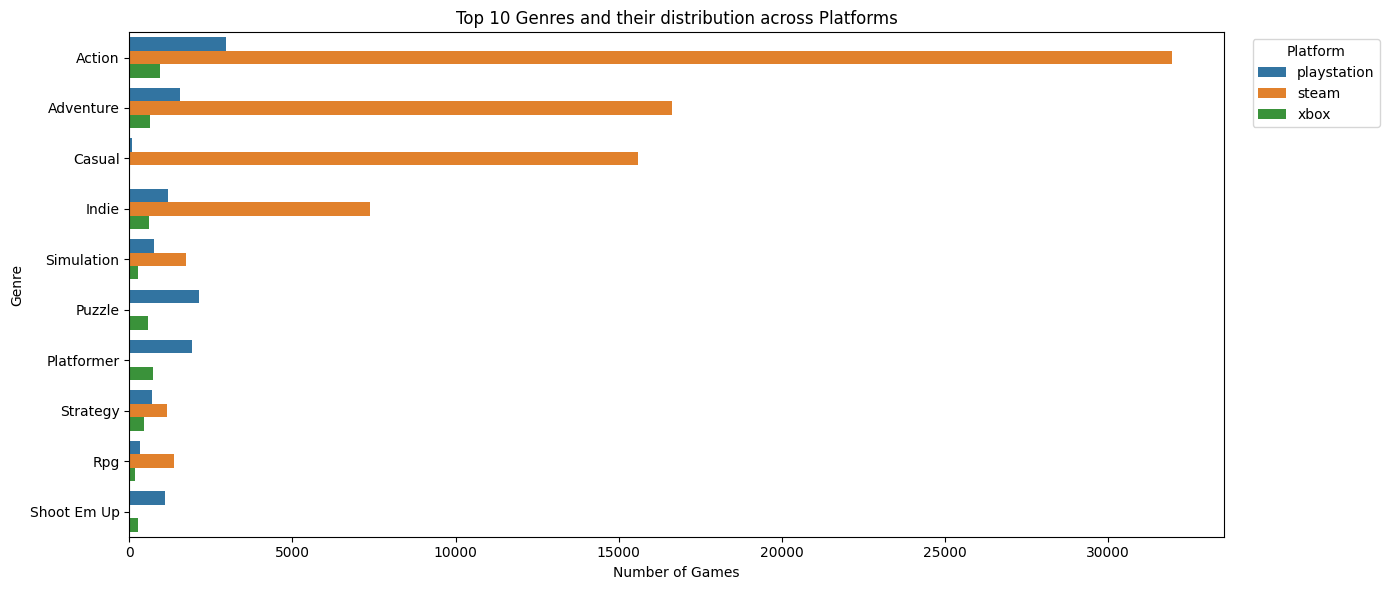

In [9]:
genre_counts = (
    df.groupby(["platform", display_genre_col])
      .size()
      .reset_index(name="count")
)

# Choose top 10 genres overall
top10_genres = (
    genre_counts.groupby(display_genre_col)["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

top_genres = genre_counts[genre_counts[display_genre_col].isin(top10_genres)]

genre_order = list(top10_genres)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=top_genres,
    y=display_genre_col, x="count",
    hue="platform",
    order=genre_order
)
plt.title("Top 10 Genres and their distribution across Platforms")
plt.xlabel("Number of Games")
plt.ylabel("Genre")
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


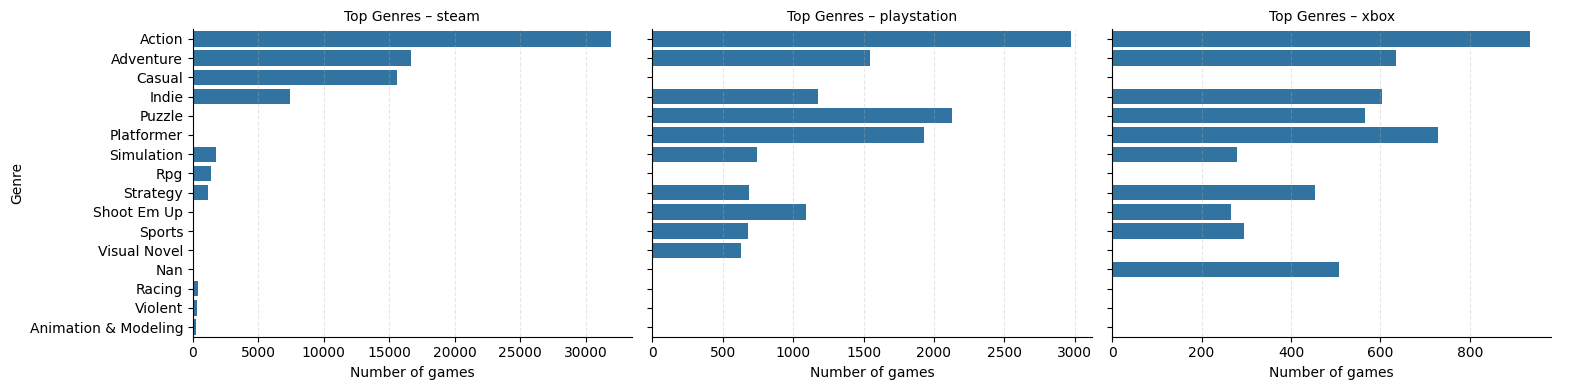

In [10]:
# Top 10 genres per platform
top_genres_per_plat = (
    genre_counts.sort_values("count", ascending=False)
    .groupby("platform")
    .head(10) )
# Sort within each platform so bars are ordered
top_genres_per_plat["rank_within_platform"] = (
    top_genres_per_plat.groupby("platform")["count"].rank("dense", ascending=False) )

# Facet: one column per platform

g = sns.catplot(
    data=top_genres_per_plat,
    kind="bar",
    x="count", y=display_genre_col,
    col="platform", col_wrap=3,
    sharex=False, height=4, aspect=1.3 )

g.set_titles("Top Genres – {col_name}")
g.set_axis_labels("Number of games", "Genre")
for ax in g.axes.flatten():
  ax.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

####Interactive Version

In [11]:
fig_q3_interactive = px.bar(
    top_genres,
    x="count",
    y=display_genre_col,
    color="platform",
    orientation="h",
    title="Top 10 Genres by Platform",
    labels={
        "count": "Number of Games",
        display_genre_col: "Genre",
        "platform": "Platform"
    },
    barmode="group",        # grouped bars for each platform
    hover_data=["platform", "count"]
)

fig_q3_interactive.update_layout(
    yaxis=dict(categoryorder="total ascending"),  # keeps order by count
    legend_title_text="Platform"
)
fig_q3_interactive.show()


In [12]:
fig_q3_per_plat_interactive = px.bar(
    top_genres_per_plat,
    x="count",
    y=display_genre_col,
    color="platform",
    facet_col="platform",
    facet_col_wrap=3,
    orientation="h",
    title="Top 10 Genres per Platform",
    labels={
        "count": "Number of games",
        display_genre_col: "Genre",
        "platform": "Platform"
    }
)

fig_q3_per_plat_interactive.update_layout(
    yaxis=dict(categoryorder="total ascending"),
    legend_title_text="Platform",
    margin=dict(l=60, r=20, t=60, b=40)
)

fig_q3_per_plat_interactive.show()

###Q4: How do prices vary by genre and platform?

#### Normal Version

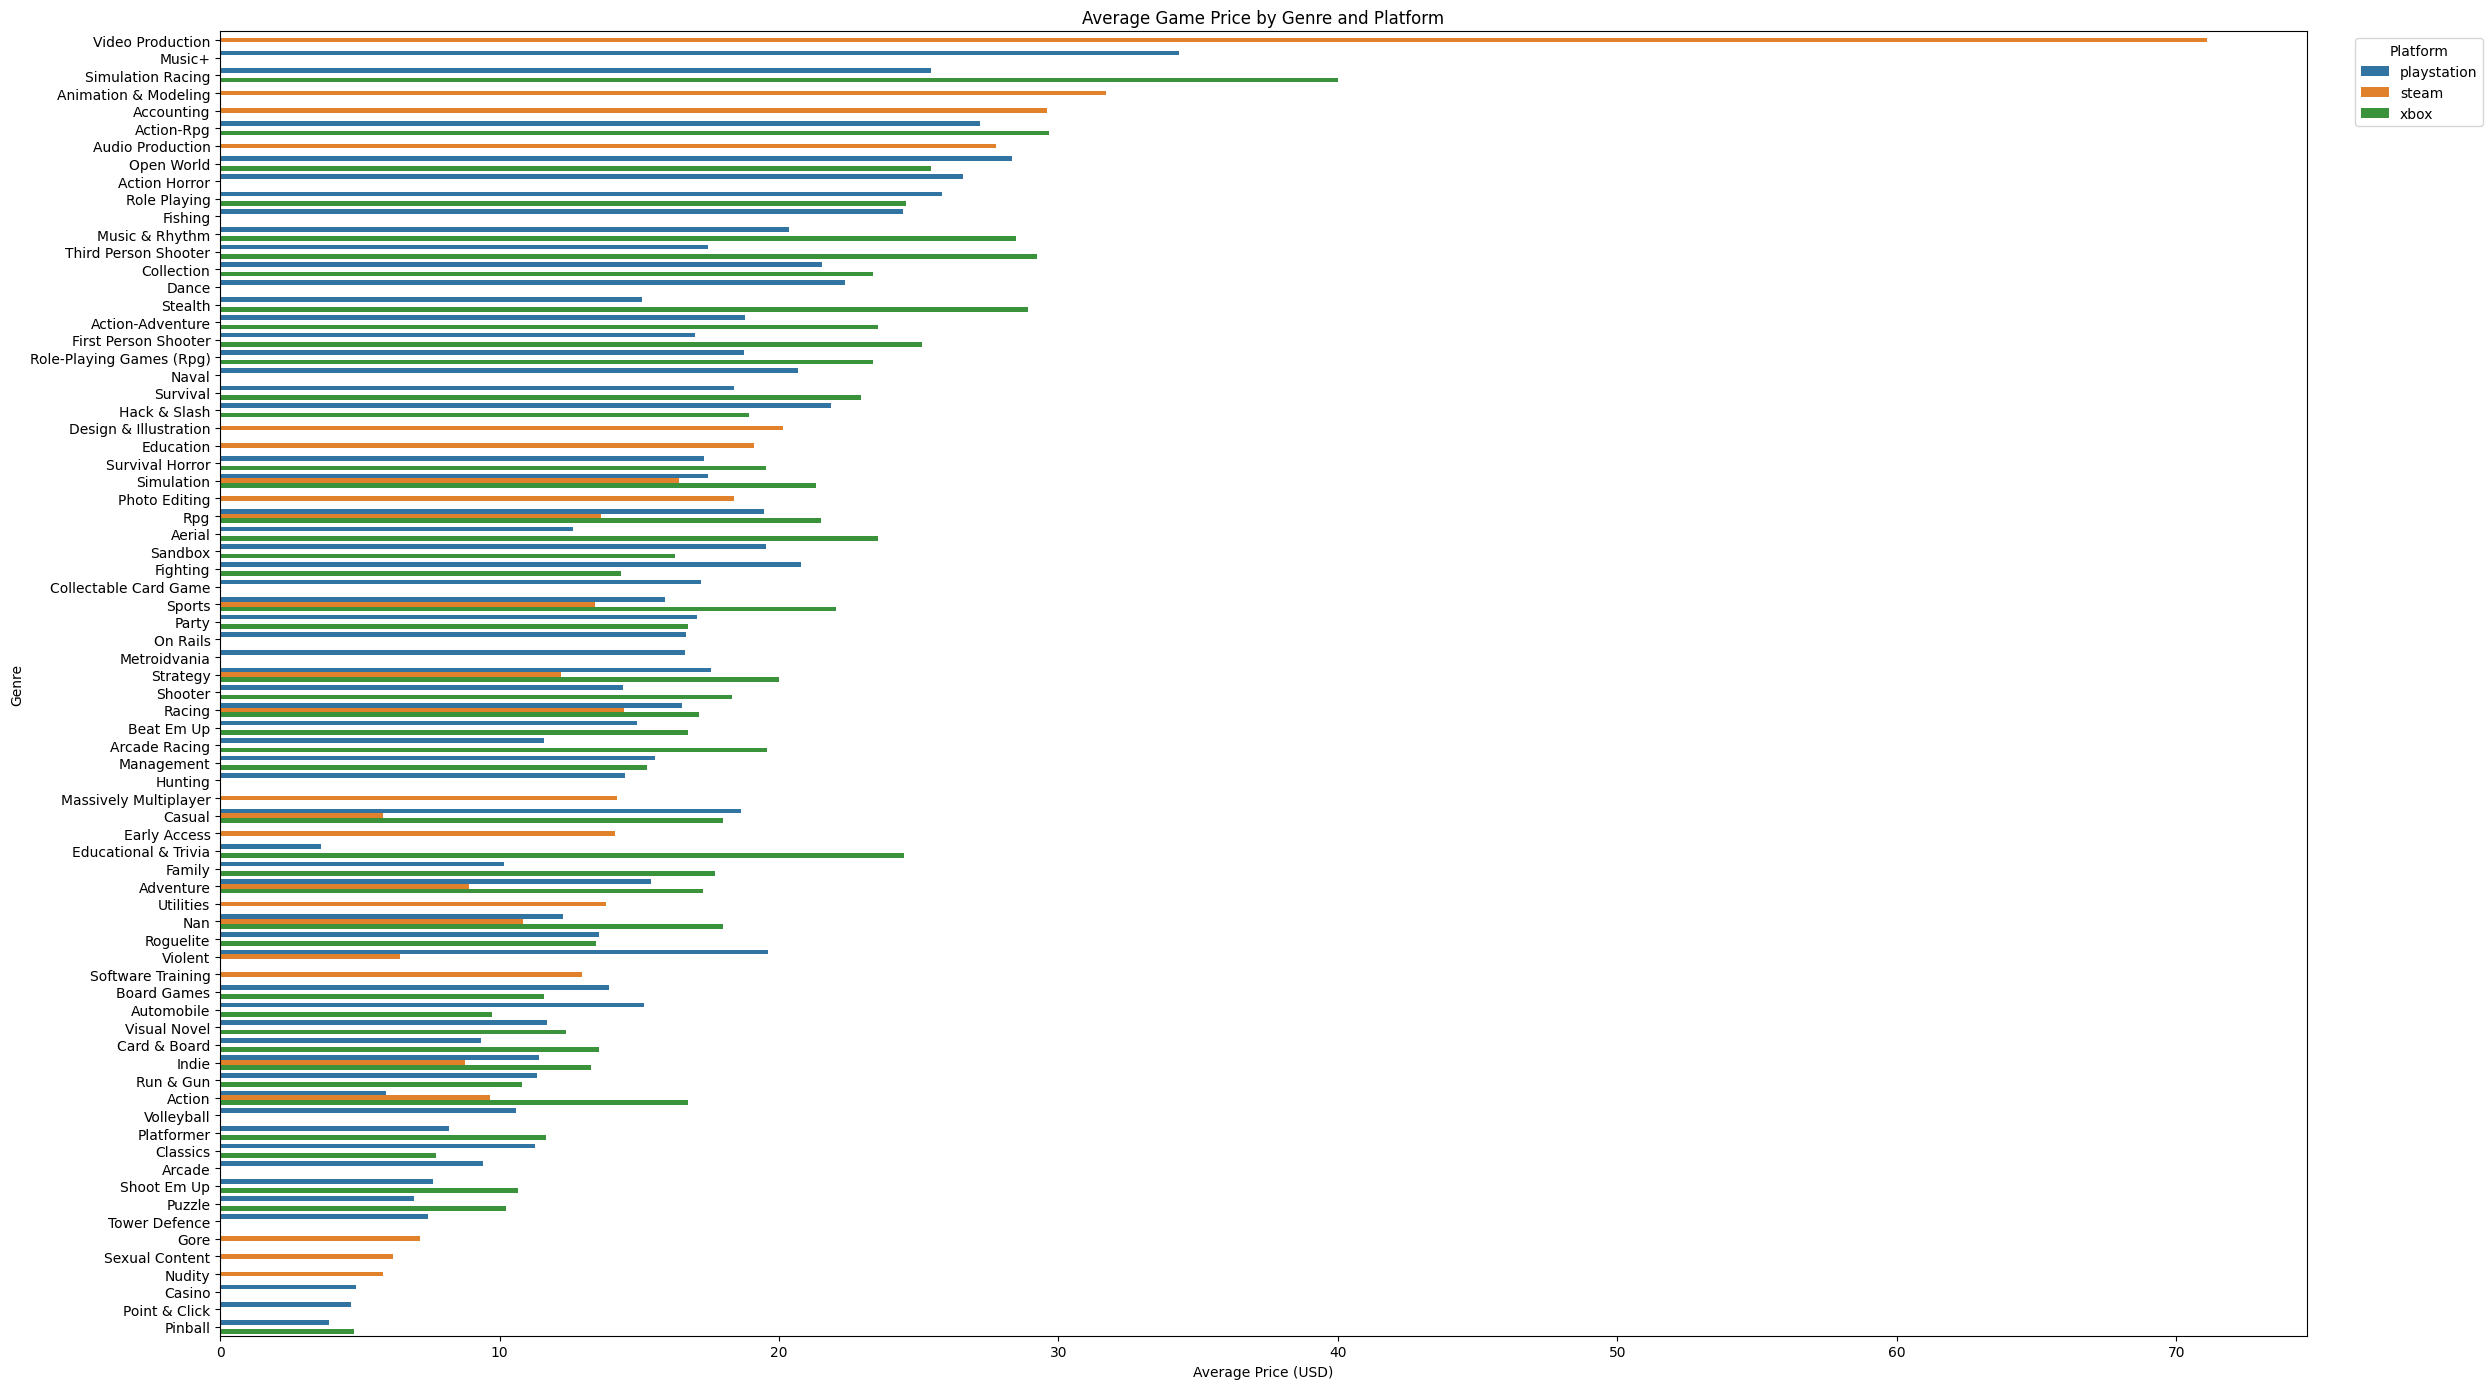

In [13]:
# Count how many games per platform+genre
counts = (
    df.groupby(["platform", display_genre_col])["prices"]
      .size()
      .reset_index(name="n_games")
)

avg_price_genre = (
    df.groupby(["platform", display_genre_col])["prices"]
      .mean()
      .reset_index()
      .merge(counts, on=["platform", display_genre_col])
)

# Filter out very rare combos (e.g., < 10 games)
min_games = 10
avg_price_genre_filtered = avg_price_genre[avg_price_genre["n_games"] >= min_games]

# Compute overall average price per genre (across platforms) for ordering
genre_price_order = (
    avg_price_genre_filtered.groupby(display_genre_col)["prices"]
    .mean()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(25, 14))
sns.barplot(
    data=avg_price_genre_filtered,
    x="prices", y=display_genre_col,
    hue="platform",
    order=genre_price_order
)
plt.title("Average Game Price by Genre and Platform")
plt.xlabel("Average Price (USD)")
plt.ylabel("Genre")
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


####Interactive Version

In [14]:
fig_q4_interactive = px.bar(
    avg_price_genre_filtered,
    x="prices",
    y=display_genre_col,
    color="platform",
    orientation="h",
    title="Average Game Price by Genre and Platform",
    labels={
        "prices": "Average Price (USD)",
        display_genre_col: "Genre",
        "platform": "Platform",
        "n_games": "Number of Games"
    },
    hover_data=["platform", "prices", "n_games"],
    barmode="group"
)

fig_q4_interactive.update_layout(
    yaxis=dict(categoryorder="total ascending", categoryarray=list(genre_price_order)),
    legend_title_text="Platform",
    width=2000,
    height=1800
)

fig_q4_interactive.show()


Q5: Which years have the most account created?

In [24]:
def load_platform_players(base_path, platform_name):
    platform_dir = os.path.join(base_path, platform_name)
    players_path = os.path.join(platform_dir, "players.csv")
    if os.path.exists(players_path):
        players_df = pd.read_csv(players_path)
        players_df["platform"] = platform_name
        return players_df
    return pd.DataFrame() # Return empty DataFrame if file not found

# Load players data for each platform
playstation_players = load_platform_players(path, "playstation")
xbox_players = load_platform_players(path, "xbox")
steam_players = load_platform_players(path, "steam")

# Concatenate all players data
players_all = pd.concat([playstation_players, xbox_players, steam_players], ignore_index=True)

# Check if 'created' column exists in players_all
if 'created' in players_all.columns:
    players_all['created'] = pd.to_datetime(players_all['created'], errors='coerce')
    players_all['creation_year'] = players_all['created'].dt.year

    creation_year_data_plotly = players_all.dropna(subset=['creation_year'])

    # Count the occurrences of each creation year
    creation_year_counts = creation_year_data_plotly['creation_year'].value_counts().sort_index().reset_index()
    creation_year_counts.columns = ['creation_year', 'count']

    # Create an interactive bar plot using Plotly Express
    fig = px.bar(creation_year_counts,
                 x='creation_year',
                 y='count',
                 title='Interactive Distribution of Account Creation Years')

    # Update x-axis to display years as integers
    fig.update_layout(xaxis = dict(tickmode = 'linear'))

    fig.show()
else:
    print("The 'created' column was not found in the players data. Cannot plot account creation years.")

## Prepare Data for Machine Learning



In [25]:
X = df[["platform", "genres", "release_year"]]
y = df["is_high_price"]

categorical_features = ["platform", "genres"]
numerical_features = ["release_year"]

# Display the first few rows of X and y to confirm
print("Features (X) head:")
display(X.head())
print("\nTarget (y) head:")
display(y.head())

Features (X) head:


,platform,genres,release_year
0,playstation,Puzzle,2024
1,playstation,Nan,2024
2,playstation,Visual Novel,2024
3,playstation,Puzzle,2024
4,playstation,Puzzle,2024



Target (y) head:


0    0
1    0
2    0
3    0
4    0
Name: is_high_price, dtype: int64

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("ColumnTransformer 'preprocessor' created successfully.")

ColumnTransformer 'preprocessor' created successfully.


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split into training and testing sets.
X_train shape: (84790, 3)
X_test shape: (21198, 3)
y_train shape: (84790,)
y_test shape: (21198,)


## Define and Train Machine Learning Models
- Logistic Regression
- Random Forest Classifier
- Support Vector Machine

In [28]:
from sklearn import svm

log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm.SVC(random_state=42)) # Corrected to svm.SVC
])

models = {
    'Logistic Regression': log_reg_pipeline,
    'Random Forest': rf_pipeline,
    'SVM': svm_pipeline 
}

print("ML model pipelines created successfully.")
print(f"Models initialized: {list(models.keys())}")

ML model pipelines created successfully.
Models initialized: ['Logistic Regression', 'Random Forest', 'SVM']


### N-Fold Cross Validation

In [29]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = {}

for name, pipeline in models.items():
    print(f"Performing {n_splits}-fold cross-validation for {name}...")
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    results[name] = scores
    print(f"  Mean accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

print("\nCross-validation complete. Results stored.")

Performing 5-fold cross-validation for Logistic Regression...
  Mean accuracy: 0.6850 (+/- 0.0012)
Performing 5-fold cross-validation for Random Forest...
  Mean accuracy: 0.6875 (+/- 0.0021)
Performing 5-fold cross-validation for SVM...
  Mean accuracy: 0.6891 (+/- 0.0010)

Cross-validation complete. Results stored.


### Model Evaluation


--- Evaluating Logistic Regression ---
Accuracy Score: 0.6847
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80     14223
           1       0.57      0.16      0.25      6975

    accuracy                           0.68     21198
   macro avg       0.64      0.55      0.53     21198
weighted avg       0.66      0.68      0.62     21198

Confusion Matrix:


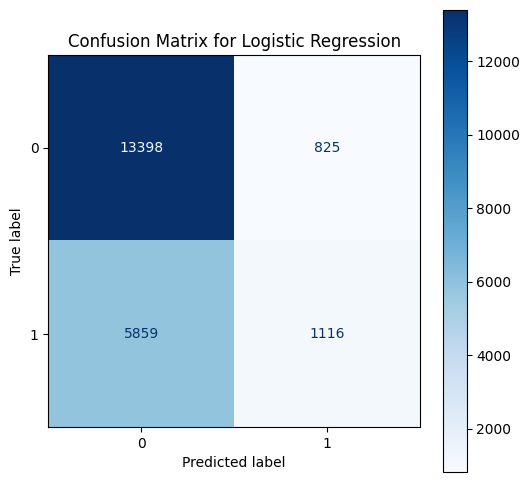


--- Evaluating Random Forest ---
Accuracy Score: 0.6908
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80     14223
           1       0.60      0.18      0.28      6975

    accuracy                           0.69     21198
   macro avg       0.65      0.56      0.54     21198
weighted avg       0.67      0.69      0.63     21198

Confusion Matrix:


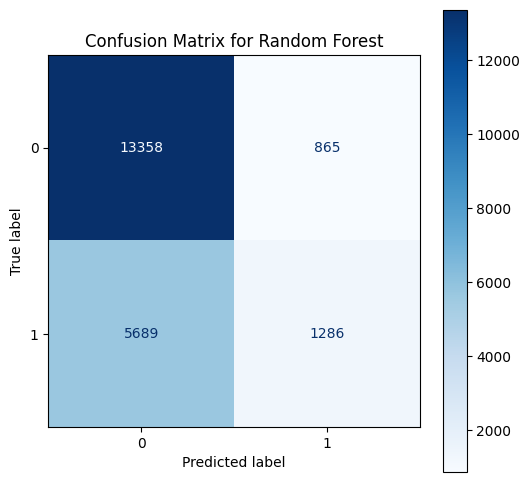


--- Evaluating SVM ---
Accuracy Score: 0.6896
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.80     14223
           1       0.61      0.16      0.25      6975

    accuracy                           0.69     21198
   macro avg       0.65      0.55      0.53     21198
weighted avg       0.67      0.69      0.62     21198

Confusion Matrix:


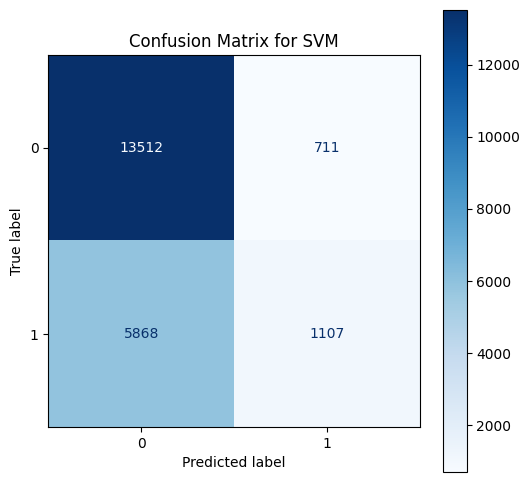

In [30]:
for name, pipeline in models.items():
    print(f"\n--- Evaluating {name} ---")

    # Train the model on the full training set
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate and print accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score: {accuracy:.4f}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Display Confusion Matrix
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

### Summary

*   All three models (Logistic Regression, Random Forest, SVM) achieved ~68-69% accuracy on predicting high-price games
*   Random Forest performed best (69.08% test accuracy), followed closely by SVM (68.96%) and Logistic Regression (68.47%)
*   Models show strong precision for low-price games (~70%) but lower recall for high-price games (~16-18%), indicating class imbalance challenges
*   Cross-validation results were consistent with test performance, suggesting stable model behavior
